In [3]:
import fastai
import transformers
import numpy as np 
import pandas as pd 
from pathlib import Path 
import random 
import os
import nltk
import math
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import dates
from datetime import datetime
import re
import calendar
import json
from functools import partial
import time
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from psutil import virtual_memory


import torch
import torch.optim as optim


# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig
from transformers import AdamW

# scikit-learn
from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler

# spacy
import spacy
from spacy.lang.en import English

#scipy
from scipy.stats import ks_2samp

print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)
print(torch.__version__)

I1108 23:23:40.135612 47228121849664 file_utils.py:39] PyTorch version 1.7.0 available.
/home/nafis/jupyter_py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nafis/jupyter_py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nafis/jupyter_py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int

fastai version : 1.0.61
transformers version : 3.0.2
1.7.0


# Check GPU Setup

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Please enable gpu ')
else:
    print(gpu_info)
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))


Tue Nov  3 12:14:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:18:00.0 Off |                    0 |
| N/A   33C    P0    41W / 300W |     11MiB / 32510MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:3B:00.0 Off |                    0 |
| N/A   32C    P0    40W / 300W |     11MiB / 32510MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## Why Transformer models?

TL DR: SOTA!

The Transformer from <a href="https://arxiv.org/pdf/1706.03762.pdf">“Attention is All You Need”</a>
 has been on a lot of people’s minds over the last year. Besides producing major improvements in translation quality, it provides a new architecture for many other NLP tasks. 

An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.

Transformers are also being used for image problems. Check out  <a href="https://arxiv.org/pdf/2010.11929.pdf">“An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale”</a>

# Main transformers classes
In transformers, each model architecture is associated with 3 main types of classes:

A model class to load/store a particular pre-train model.
A tokenizer class to pre-process the data and make it compatible with a particular model.
A configuration class to load/store the configuration of a particular model.

In [6]:
#main transformers class 
#https://huggingface.co/transformers/pretrained_models.html#pretrained-models
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig),
    
}


The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.


# Global Variables

In [7]:
# Parameters

### seed value for model reproducability ###
seed = 1337

### precision for ###
use_fp16 = False

### batch size ###

bs = 16

### Choose model ###


model_type = 'roberta'
pretrained_model_name = 'roberta-base'

# model_type = 'bert'
# pretrained_model_name='bert-base-cased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

### text variables ###
text_column = "essay"
target_col = "domain1_score"


### Transformer Hyperparameters ###

hidden_dropout_prob = 0.01
initializer_range = 0.2
layer_norm_eps = 1e-05
attention_probs_dropout_prob = 0.1
learning_wd = 0.1

## Utility Functions

In [6]:
kappa = KappaScore()
kappa.weights = "quadratic"
f_score = partial(fbeta, thresh=0.2, beta = 1)
from sklearn.metrics import roc_auc_score

def my_auc(inp, targ):
    "Simple wrapper around scikit's roc_auc_score function for regression problems"
    inp,targ = flatten_check(inp,targ)
    return roc_auc_score(targ.cpu().numpy(), inp.cpu().numpy())

def setup_learner(databunch,initial=True,layer=1,model=None,path=None):
    """
    Setup learner instance and optimizer
    """
    
    if not initial:
        learner = load_learner(path,model)
        learner.data = databunch
    else:
        CustomAdamW = partial(AdamW, correct_bias=False,weight_decay=0.1)
        learner = Learner(databunch, 
                          custom_transformer_model, 
                          opt_func = CustomAdamW,
                          metrics=[kappa,accuracy,error_rate])

    ### Show graph of learner stats and metrics after each epoch ###
    learner.callbacks.append(ShowGraph(learner))
    
    # Put learn in FP16 precision mode. --> Seems to not working
    if use_fp16: 
        learner = learner.to_fp16()
        
        
    # For DistilBERT
    # list_layers = [learner.model.transformer.distilbert.embeddings,
    #                learner.model.transformer.distilbert.transformer.layer[0],
    #                learner.model.transformer.distilbert.transformer.layer[1],
    #                learner.model.transformer.distilbert.transformer.layer[2],
    #                learner.model.transformer.distilbert.transformer.layer[3],
    #                learner.model.transformer.distilbert.transformer.layer[4],
    #                learner.model.transformer.distilbert.transformer.layer[5],
    #                learner.model.transformer.pre_classifier]

    # For xlnet-base-cased
    # list_layers = [learner.model.transformer.transformer.word_embedding,
    #               learner.model.transformer.transformer.layer[0],
    #               learner.model.transformer.transformer.layer[1],
    #               learner.model.transformer.transformer.layer[2],
    #               learner.model.transformer.transformer.layer[3],
    #               learner.model.transformer.transformer.layer[4],
    #               learner.model.transformer.transformer.layer[5],
    #               learner.model.transformer.transformer.layer[6],
    #               learner.model.transformer.transformer.layer[7],
    #               learner.model.transformer.transformer.layer[8],
    #               learner.model.transformer.transformer.layer[9],
    #               learner.model.transformer.transformer.layer[10],
    #               learner.model.transformer.transformer.layer[11],
    #               learner.model.transformer.sequence_summary]

    # For roberta-base
    list_layers = [learner.model.transformer.roberta.embeddings,
                  learner.model.transformer.roberta.encoder.layer[0],
                  learner.model.transformer.roberta.encoder.layer[1],
                  learner.model.transformer.roberta.encoder.layer[2],
                  learner.model.transformer.roberta.encoder.layer[3],
                  learner.model.transformer.roberta.encoder.layer[4],
                  learner.model.transformer.roberta.encoder.layer[5],
                  learner.model.transformer.roberta.encoder.layer[6],
                  learner.model.transformer.roberta.encoder.layer[7],
                  learner.model.transformer.roberta.encoder.layer[8],
                  learner.model.transformer.roberta.encoder.layer[9],
                  learner.model.transformer.roberta.encoder.layer[10],
                  learner.model.transformer.roberta.encoder.layer[11],
                  learner.model.transformer.roberta.pooler]
    learner.split(list_layers)
    num_groups = len(learner.layer_groups)
    seed_all(seed)
    return learner,num_groups

# Model Reproducibility
Some important parts of the machine learning workflow where randomness appears:

1. Data Preparation
2. Pre-processing
3. Cross-validation
4. Weight initialization
5. Hidden layers in the network
6. Algorithms 

Setting the random seed across your pipeline you can achieve reproducibility. The “seed” is a starting point for the sequence and the guarantee is that if you start from the same seed you will get the same sequence of numbers. 

In [7]:
def seed_all(seed_value):
    """
    Setting the random seed across the pipeline
    """
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) 
    np.random.seed(seed_value) # cpu vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
seed_all(seed)


# Text Preprocess



#### Summary of pre-process:
We first tokenize and then numericalize our input

processor = [TokenizeProcessor(tokenizer=tokenizer,...), NumericalizeProcessor(vocab=vocab,...)]

Let's first analyse how we can integrate the transformers tokenizer within the TokenizeProcessor function.

We can simply create a new class TransformersBaseTokenizer that inherits from BaseTokenizer and overwrite a new tokenizer function.

# Create Tokenizer Function¶



In [8]:
class TransformersBaseTokenizer(BaseTokenizer):
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        "RoBERTa require a space to start the input string. For those models," 
        "the encoding methods should be called with add_prefix_space set to True"
        if self.model_type in ['roberta']:
            "we have to limit the sequence length to the model input size."
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

From Huggingface documentation

bert:       [CLS] + tokens + [SEP] + padding

roberta:    [CLS] + prefix_space + tokens + [SEP] + padding

distilbert: [CLS] + tokens + [SEP] + padding

xlnet:      padding + tokens + [SEP] + [CLS]

Note: Padding is added by fastai when we create DataBunch

# Create Numericalizer Function¶

In fastai, NumericalizeProcessor object takes as vocab argument a Vocab object. 

In [9]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})
        
        
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits
    
    
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]


def get_class_weights():

    """
    Returns class weights for CrossEntropy Loss
    """
    class_count_df = asap_train.groupby(target_col).count();class_count_df
    class_count_df.iloc[0, 0]
    class_count_df.iloc[2, 0]
    n_0, n_1,n_2,n_3,n_4,n_5 = class_count_df.iloc[0, 0], class_count_df.iloc[1, 0],class_count_df.iloc[2, 0],class_count_df.iloc[3, 0],class_count_df.iloc[4, 0],class_count_df.iloc[5, 0]
    w_0 = (n_0 + n_1 + n_2 + n_3 + n_4) / (6.0 * n_0)
    w_1 = (n_0 + n_1 + n_2 + n_3 + n_4) / (6.0 * n_1)
    w_2 = (n_0 + n_1 + n_2 + n_3 + n_4) / (6.0 * n_2)
    w_3 = (n_0 + n_1 + n_2 + n_3 + n_4) / (6.0 * n_3)
    w_4 = (n_0 + n_1 + n_2 + n_3 + n_4) / (6.0 * n_4)
    w_5 = (n_0 + n_1 + n_2 + n_3 + n_4) / (6.0 * n_5)
    # # Important: Convert Weights To Float Tensor
    class_weights=torch.FloatTensor([w_0, w_1,w_2,w_3,w_4,w_5]).cuda()
    return class_weights


# Custom processor
 fastai adds its own special tokens by default which interferes with the [CLS] and [SEP] tokens added by our custom tokenizer.
 

# Simple Data exploration

In [8]:
df = pd.read_csv("training_set_rel3.tsv", sep='\t',encoding='ISO-8859-1')
df = df[df["essay_set"]==2]
df = df.sample(frac=1)

I1108 23:25:17.556693 47228121849664 utils.py:129] Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
I1108 23:25:17.558328 47228121849664 utils.py:141] NumExpr defaulting to 8 threads.


[4    43.222222
3    42.388889
2     8.500000
5     4.166667
1     1.333333
6     0.388889
Name: domain1_score, dtype: float64]


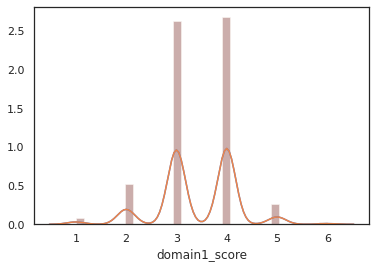

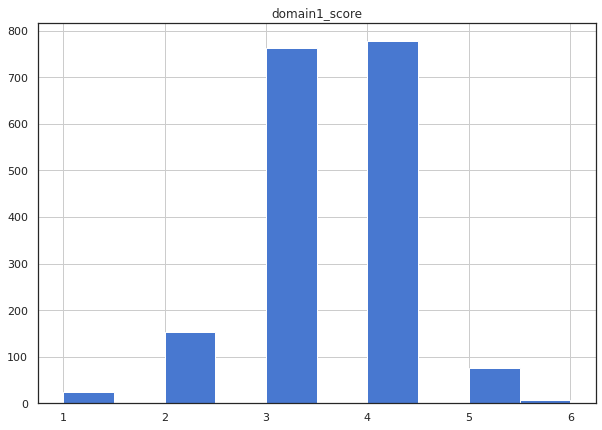

In [9]:
sns.set(color_codes=True)
sns.set(style="white", palette="muted")

def plot_distribution(df):
    """
    Shows distribution
    """
    df = df[[target_col]]
    print ([df[i].value_counts()/len(df)*100 for i in df.columns])
    sns.distplot(df)
    for col_id in df.columns:
        sns.distplot(df[col_id])
    df.hist(figsize=(10,7))
    
plot_distribution(df)

#### Imbalanced dataset

Our dataset is imbalanced. To tackle this problem I have changed the following which improved the result than the current state of art model:
1.Stratifiy sampling based on our target variable
2.For the loss function I use Crossentropy loss with weights
3.Changed metric from accuracy to Cohen's kappa which is a better metric for imbalanced data as it takes into account of chance agreement between our model and ground truth. 

Note: Accuracy is a really bad metric for this dataset due to the imbalance

#### Stratify based on label column
To tackle imbalance dataset we are stratifying our train and test split

In [11]:
seed_all(seed)
asap_train, asap_test = train_test_split(df, test_size=0.1, stratify=df[[target_col]])

seed_all(seed)
train, test = train_test_split(df, test_size=0.1, stratify=df[[target_col]])

# Make sure the seed is working properly and is reproducible

asap_train.equals(train)
asap_test.equals(test)
asap_test.describe()
asap_train.describe()

True

True

,essay_id,essay_set,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
count,180.000000,180.0,180.000000,180.000000,0.0,180.000000,180.000000,180.000000,180.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,3865.027778,2.0,3.433333,3.444444,NaN,3.433333,3.333333,3.300000,3.333333,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,518.134270,0.0,0.777476,0.771143,NaN,0.777476,0.739923,0.716135,0.739923,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2995.000000,2.0,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3416.250000,2.0,3.000000,3.000000,NaN,3.000000,3.000000,3.000000,3.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,3900.000000,2.0,3.000000,4.000000,NaN,3.000000,3.000000,3.000000,3.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,4302.250000,2.0,4.000000,4.000000,NaN,4.000000,4.000000,4.000000,4.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,4766.000000,2.0,6.000000,5.000000,NaN,6.000000,4.000000,4.000000,4.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,essay_id,essay_set,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
count,1620.000000,1620.0,1620.000000,1620.000000,0.0,1620.000000,1620.000000,1620.000000,1620.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,3878.885802,2.0,3.413580,3.435802,NaN,3.413580,3.333951,3.333951,3.333951,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,520.080908,0.0,0.774398,0.776557,NaN,0.774398,0.728122,0.728122,0.728122,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2978.000000,2.0,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3429.750000,2.0,3.000000,3.000000,NaN,3.000000,3.000000,3.000000,3.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,3874.000000,2.0,3.000000,3.000000,NaN,3.000000,3.000000,3.000000,3.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,4331.250000,2.0,4.000000,4.000000,NaN,4.000000,4.000000,4.000000,4.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,4777.000000,2.0,6.000000,6.000000,NaN,6.000000,4.000000,4.000000,4.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#  Kolmogorov Smirnov Two Sample Test
Train and test split distribution 
Checking how our train and test split is distributed using Kolmogorov Smirnov Two Sample Test (herein also referred to as “KS-2”)

Under KS-2 test, we do not compare an empirical distribution function against a cumulative distribution function. Rather, we assume two empirical distributions and then take a difference between them. We do not need to assume any specific distribution. We proceed with calculating the difference between the two empirical distributions at each of the data points from our data set.
Mathematically,


$D = |E1(k)-E2(k)|$,

where
D = absolute value of the distance between two data sets

$E1(k)-E2(k)$:

are computed at each point in the given data set.

In [12]:
train = asap_train[["domain1_score"]]
tes = asap_test[["domain1_score"]]

p_value = 0.05
rejected = 0
for col in train:
    print (col)
    test = stats.ks_2samp(train[col], tes[col])
    print (test)
    if test[1] < p_value:
         rejected += 1
print("We rejected",rejected,"columns in total")

domain1_score
Ks_2sampResult(statistic=0.006172839506172839, pvalue=1.0)
We rejected 0 columns in total


In [13]:
asap_train.describe()  

,essay_id,essay_set,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
count,1620.000000,1620.0,1620.000000,1620.000000,0.0,1620.000000,1620.000000,1620.000000,1620.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,3878.885802,2.0,3.413580,3.435802,NaN,3.413580,3.333951,3.333951,3.333951,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,520.080908,0.0,0.774398,0.776557,NaN,0.774398,0.728122,0.728122,0.728122,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2978.000000,2.0,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3429.750000,2.0,3.000000,3.000000,NaN,3.000000,3.000000,3.000000,3.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,3874.000000,2.0,3.000000,3.000000,NaN,3.000000,3.000000,3.000000,3.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,4331.250000,2.0,4.000000,4.000000,NaN,4.000000,4.000000,4.000000,4.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,4777.000000,2.0,6.000000,6.000000,NaN,6.000000,4.000000,4.000000,4.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Databunch

In the fastai library, data pre-processing is done automatically during the creation of the DataBunch.

#### Databunch
A DataBunch is something that binds together a training data loader and a validation data loader.

When you look at fast.ai docs, if you don’t know what is the variable/symbol be used for you can look up elsewhere. In the class argument list, you can see train_dl is a dataloader. (argument : Type)

So when you create a DataBunch, you are giving a train and valid dataloaders. And that is now an object that you can send off to a learner. Then it will start learning. That was basic stuff.


For the DataBunch creation, we have to pay attention to set the processor argument to our new custom processor transformer_processor and manage correctly the padding.

As mentioned in the HuggingFace documentation, BERT, RoBERTa, XLM and DistilBERT are models with absolute position embeddings, so it's usually advised to pad the inputs on the right rather than the left. Regarding XLNET, it is a model with relative position embeddings, therefore, you can either pad the inputs on the right or on the left.


In [14]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

        
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)
seed_all(seed)
transformer_processor = [tokenize_processor, numericalize_processor]



databunch = (TextList.from_df(asap_train, cols=text_column, processor=transformer_processor)
         .split_by_rand_pct(0.1,seed=seed)
         .label_from_df(cols=target_col)
         .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))
    
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = asap_train[target_col].nunique()
config.use_bfloat16 = use_fp16
config.hidden_dropout_prob=hidden_dropout_prob
config.attention_probs_dropout_pro = attention_probs_dropout_prob

transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)


I1103 12:14:24.758270 47237152702144 tokenization_utils_base.py:1254] loading file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-vocab.json from cache at /home/nafis/.cache/torch/transformers/d0c5776499adc1ded22493fae699da0971c1ee4c2587111707a4d177d20257a2.ef00af9e673c7160b4d41cfda1f48c5f4cba57d5142754525572a846a1ab1b9b
I1103 12:14:24.760256 47237152702144 tokenization_utils_base.py:1254] loading file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-merges.txt from cache at /home/nafis/.cache/torch/transformers/b35e7cd126cd4229a746b5d5c29a749e8e84438b14bcdb575950584fe33207e8.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda
I1103 12:14:24.977387 47237152702144 utils.py:129] Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
I1103 12:14:24.979113 47237152702144 utils.py:141] NumExpr defaulting to 8 threads.


I1103 12:14:30.247584 47237152702144 configuration_utils.py:264] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json from cache at /home/nafis/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.117c81977c5979de8c088352e74ec6e70f5c66096c28b61d3c50101609b39690
I1103 12:14:30.250485 47237152702144 configuration_utils.py:300] Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "type_vocab_size": 1,
  "vocab_size": 50265
}

I1103 12:14:30.363060 47237152702144 mod

### Let's see Roberta model architecture 

In [ ]:
# config

# Gradual Freezing

#### Fine tuning upto four layers
According to the paper : "What Would Elsa Do? Freezing Layers During Transformer Fine-Tuning "
 The authors concludes ".. that only a fourth of the final layers need to be fine-tuned to achieve 90% of the original quality. Surprisingly, we also find that fine-tuning all layers does not always help."

#### Experiments with 1 cycle policy, Gradual unfreezing of transformer layers and Slanted Triangular Learning Rates 

In [25]:
learner,num_groups = setup_learner(databunch)
# freeze last layer
learner.freeze_to(-1)
# weight decay changed from default 0.01 to 0.1
learner.wd=0.1
# learner.summary()
learner.loss_func = CrossEntropyFlat(weight=get_class_weights())

In [ ]:
# learner.layer_groups

In [35]:
learner.lr_find()

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.98E-04
Min loss divided by 10: 1.91E-05


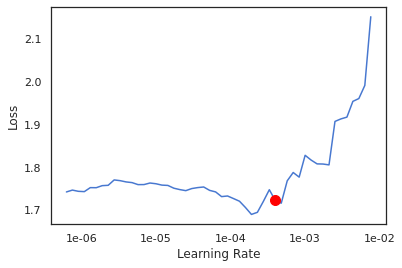

In [36]:
learner.recorder.plot(skip_end=10,suggestion=True)

#### Get the learning rate to use

In [37]:
min_grad_lr = learner.recorder.min_grad_lr
min_grad_lr
lr1 = min_grad_lr

0.0003981071705534973

## Fast AI callback to save best model

In [32]:
def get_callback(learner,name,monitor='kappa_score'):
    """
    Return SaveModelCallback with name and monitor
    """
    callbacks = [SaveModelCallback(learner, every='improvement', monitor='kappa_score', name="first_layer_asap")]
    return callbacks

##### Only the last layer is unfrozen . All the other layers are frozen

##### The 1cycle policy was introduced by Leslie N. Smith et al. in Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates. It schedules the learning rate with a cosine annealing from lr_max/div to lr_max then lr_max/div_final (pass an array to lr_max if you want to use differential learning rates) and the momentum with cosine annealing according to the values in moms.

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,2.881700,2.435776,0.081917,0.475309,0.524691,00:37
1,2.438007,2.246840,0.000000,0.098765,0.901235,00:35
2,1.801237,1.029655,0.631016,0.629630,0.370370,00:37
3,1.189882,1.178748,0.609100,0.574074,0.425926,00:33
4,1.031982,1.035703,0.661088,0.592593,0.407407,00:39


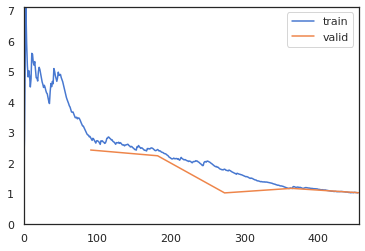

Better model found at epoch 0 with kappa_score value: 0.08191657066345215.
Better model found at epoch 2 with kappa_score value: 0.6310160160064697.
Better model found at epoch 4 with kappa_score value: 0.6610878705978394.


In [47]:
learner.fit_one_cycle(5,max_lr=min_grad_lr,moms=(0.8,0.7),callbacks=callbacks)

In [ ]:
# learner.load("first_layer_asap")

#### Export and load t

In [50]:
learner.export(os.path.abspath('./models/first_layer_asap.pkl'))

In [18]:
learner,num_groups = setup_learner(databunch,initial=False,model='first_layer_asap.pkl',path=os.path.abspath('./models'))

In [ ]:
# callbacks = [SaveModelCallback(learner, every='improvement', monitor='kappa_score', name="second_layer_asap")]
# freeze last 2 layers
learner.freeze_to(-2)
# find learning rate using lr find and plot
learner.lr_find()
learner.recorder.plot(skip_end=10,suggestion=True)
min_grad_lr = learner.recorder.min_grad_lr
min_grad_lr


#### Check which layers are trainiable after freezing

In [ ]:
# learner.summary()

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,1.034093,1.093034,0.637584,0.444444,0.555556,00:19
1,1.204128,1.754988,0.472752,0.370370,0.629630,00:19
2,1.338035,1.362049,0.430189,0.345679,0.654321,00:17
3,1.129938,1.014872,0.620520,0.407407,0.592593,00:18
4,0.913686,0.928498,0.574757,0.586420,0.413580,00:18
5,0.798007,1.000057,0.655084,0.611111,0.388889,00:19
6,0.620707,0.927682,0.654392,0.623457,0.376543,00:18
7,0.537614,0.906184,0.690323,0.641975,0.358025,00:26
8,0.498880,0.913657,0.690344,0.635802,0.364198,00:19
9,0.484318,0.926007,0.670732,0.629630,0.370370,00:19


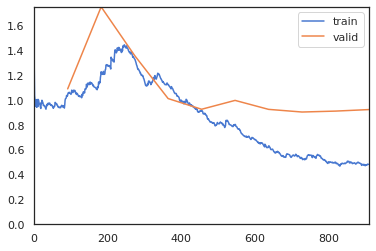

Better model found at epoch 0 with kappa_score value: 0.63758385181427.
Better model found at epoch 5 with kappa_score value: 0.6550843119621277.
Better model found at epoch 7 with kappa_score value: 0.6903225779533386.
Better model found at epoch 8 with kappa_score value: 0.6903440952301025.


In [24]:
learner.fit_one_cycle(10, max_lr=slice(min_grad_lr,0.0003981071705534973), moms=(0.8, 0.9),callbacks=get_callback())

#### Our model is overfitting. We need to use more regularization

In [ ]:
# learner.load("second_layer_asap")

In [26]:
learner.export(os.path.abspath('./models/second_layer_asap.pkl'))

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 6.31E-08


1.3182567385564074e-06

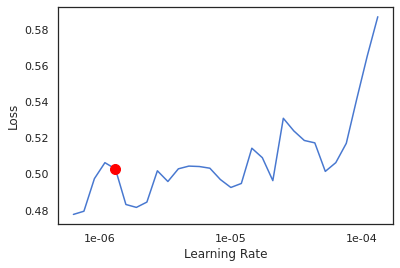

In [27]:
# callbacks = [SaveModelCallback(learner, every='improvement', monitor='kappa_score', name="third_layer_asap")]
# freeze last 3 layers
learner.freeze_to(-3)

learner.lr_find()
learner.recorder.plot(skip_end=10,suggestion=True)
min_grad_lr = learner.recorder.min_grad_lr
min_grad_lr

#### We can add weight regularization to the hidden layer to reduce the overfitting of the model to the training dataset and improve the performance on the holdout set.

In [30]:
learner.wd = 0.5

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.627760,1.581374,0.527539,0.432099,0.567901,00:38
1,0.922297,1.428094,0.466583,0.382716,0.617284,00:22
2,1.309008,0.948553,0.637712,0.604938,0.395062,00:35
3,1.207250,1.095764,0.533917,0.376543,0.623457,00:43
4,0.942807,0.923254,0.639366,0.530864,0.469136,00:37
5,0.839016,0.959865,0.636011,0.623457,0.376543,00:45
6,0.696469,0.995095,0.649823,0.617284,0.382716,00:44
7,0.552485,0.958857,0.659925,0.654321,0.345679,00:44
8,0.492147,0.998334,0.669505,0.666667,0.333333,00:44
9,0.450817,1.010724,0.650718,0.660494,0.339506,00:28


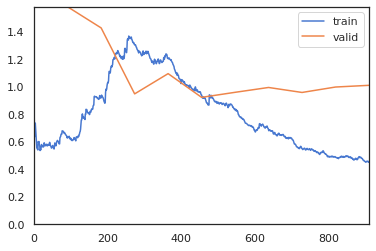

Better model found at epoch 0 with kappa_score value: 0.5275387763977051.
Better model found at epoch 2 with kappa_score value: 0.6377118825912476.
Better model found at epoch 4 with kappa_score value: 0.6393659114837646.
Better model found at epoch 6 with kappa_score value: 0.6498230695724487.
Better model found at epoch 7 with kappa_score value: 0.6599254608154297.
Better model found at epoch 8 with kappa_score value: 0.6695050597190857.


In [31]:
learner.fit_one_cycle(10, max_lr=slice(min_grad_lr,0.0003981071705534973), moms=(0.8, 0.9),callbacks=get_callback())

In [ ]:
# learner.load("third_layer_asap")

In [33]:
learner.export(os.path.abspath('./models/third_layer_asap.pkl'))

In [ ]:
learner,num_groups = setup_learner(databunch,initial=False,model='third_layer_asap.pkl',path=os.path.abspath('./models'))

#### Unfreezing all the layers

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-06
Min loss divided by 10: 1.10E-07


4.7863009232263826e-06

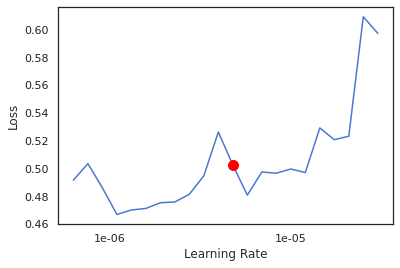

In [34]:
learner.unfreeze()
callbacks = [SaveModelCallback(learner, every='improvement', monitor='kappa_score', name="all_layer_asap")]

learner.lr_find()
learner.recorder.plot(skip_end=10,suggestion=True)
min_grad_lr = learner.recorder.min_grad_lr
min_grad_lr

#### Our model is overffiting from previous epoch so increase regularization 

In [1]:
learner.wd = 0.8

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.926684,1.072493,0.621179,0.524691,0.475309,01:01
1,1.374946,1.804573,0.312611,0.370370,0.629630,00:51
2,1.686002,1.791751,0.147368,0.407407,0.592593,01:25
3,1.650083,1.571538,0.338363,0.253086,0.746914,01:23
4,1.476411,1.352497,0.401977,0.469136,0.530864,01:21
5,1.256363,1.092323,0.627770,0.672840,0.327161,01:24
6,1.091317,1.183685,0.446240,0.518519,0.481481,01:28
7,0.954312,1.022205,0.693498,0.697531,0.302469,01:25
8,0.869017,1.001675,0.681464,0.672840,0.327161,01:27
9,0.811004,0.982947,0.683314,0.672840,0.327161,01:33


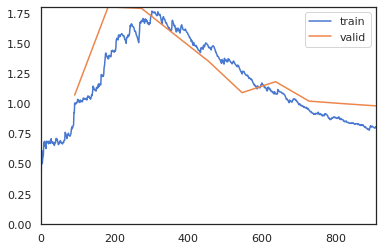

Better model found at epoch 0 with kappa_score value: 0.6211785674095154.
Better model found at epoch 5 with kappa_score value: 0.6277695894241333.
Better model found at epoch 7 with kappa_score value: 0.6934984922409058.


In [37]:
learner.fit_one_cycle(10, max_lr=slice(min_grad_lr,0.0003981071705534973), moms=(0.8, 0.9),callbacks=callbacks)

In [ ]:
# learner.load("all_layer_asap")

In [39]:
learner.export(os.path.abspath('./models/all_layer_asap.pkl'))

In [16]:
learner,num_groups = setup_learner(databunch,initial=False,model='all_layer_asap.pkl',path=os.path.abspath('./models'))

# Prediction

Load the test data in the databunch for model prediction. Let's checkout our predictions!

In [17]:
data_test = (TextList.from_df(asap_test, cols=text_column, processor=transformer_processor)
         .split_none()
         .label_from_df(cols=target_col))

data_test.valid = data_test.train
data_test = data_test.databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx)
learner.data.valid_dl = data_test.valid_dl
preds, y = learner.get_preds(ds_type=DatasetType.Valid)

In [19]:
pred = torch.argmax(preds, dim=1)

<Figure size 720x504 with 0 Axes>

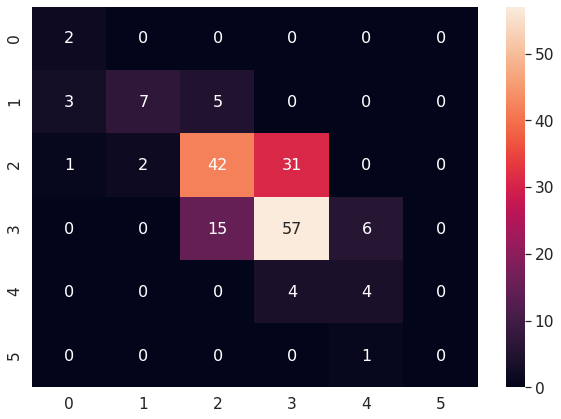

In [22]:
cm = confusion_matrix(y,pred)
df_cm = pd.DataFrame(cm, range(6), range(6))
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size

plt.show()

# Result

Our model performs as same as the one in the paper! 

In [23]:
cohen_score = cohen_kappa_score(y, pred,weights='quadratic')
cohen_score

0.6918402777777778

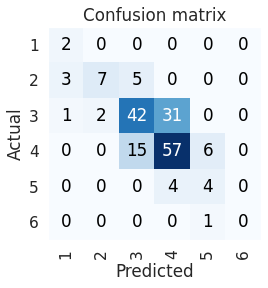

In [24]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()


In [48]:
text = "This is a random essay derp derp!"
preds= learner.predict(text)
preds[0]

Category tensor(1)

# Further improvement using hyperparameter tuning and k-fold stratified sampling

In [49]:
learner,num_groups = setup_learner(databunch,initial=False,model='best_all_layersss_asap.pkl',path=os.path.abspath('./models'))

In [19]:
learner.loss_func = CrossEntropyFlat(weight=get_class_weights())

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06
Min loss divided by 10: 3.02E-04


2.754228703338166e-06

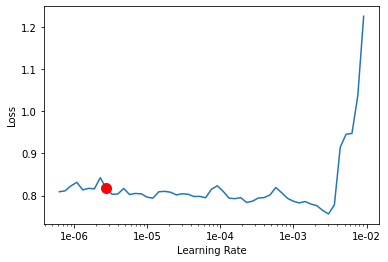

In [20]:
learner.lr_find()
learner.recorder.plot(skip_end=10,suggestion=True)
min_grad_lr = learner.recorder.min_grad_lr
min_grad_lr

# Final Result 

Below our model is showing an average of 0.738 on cross validation set which is an improvement of ~10% over the paper Should You Fine-Tune BERT for Automated Essay Scoring? . The authors best cross validation score on ASAP essay set 2 is 0.64.

1.4317922829798579e-05

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.865306,0.822168,0.724726,0.672840,0.327161,00:34


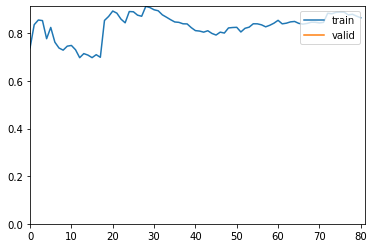

1.4317922829798579e-05

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.788025,0.899076,0.714643,0.666667,0.333333,00:15


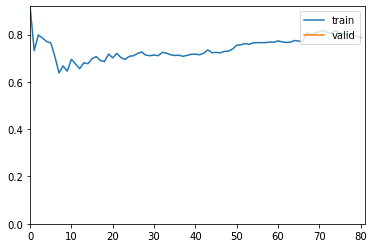

1.4317922829798579e-05

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.849485,0.786476,0.741214,0.654321,0.345679,00:19


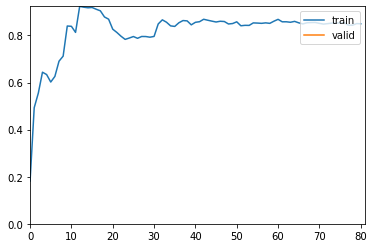

1.4317922829798579e-05

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.804284,0.744626,0.726809,0.648148,0.351852,00:28


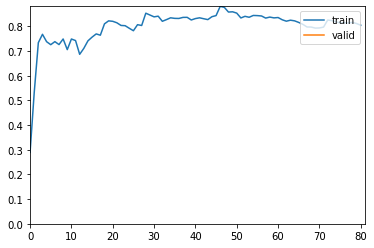

1.4317922829798579e-05

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.789002,0.678092,0.723668,0.666667,0.333333,00:16


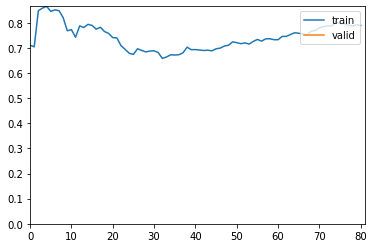

KAPPA MEAN 68.23854206378586


3.5794807074496447e-06

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.792432,0.834032,0.696037,0.638889,0.361111,00:26


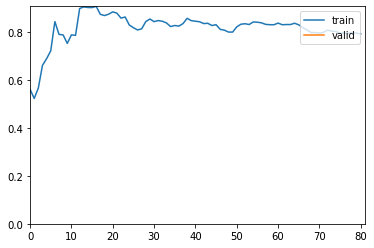

3.5794807074496447e-06

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.776189,0.886434,0.728316,0.685185,0.314815,00:16


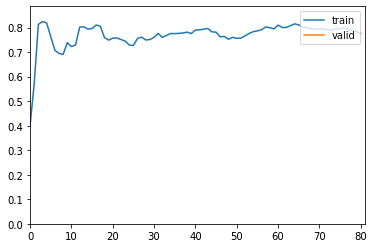

3.5794807074496447e-06

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.816922,0.761720,0.712579,0.641975,0.358025,00:17


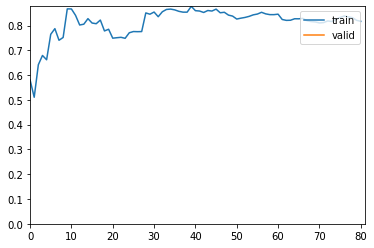

3.5794807074496447e-06

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.850559,0.757134,0.778272,0.688272,0.311728,00:29


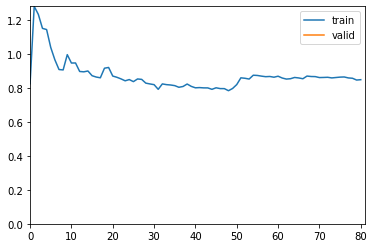

3.5794807074496447e-06

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.923378,0.793572,0.757912,0.682099,0.317901,00:15


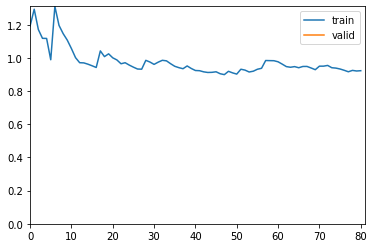

KAPPA MEAN 68.85660128108503


8.948701768624112e-07

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.794721,0.838209,0.698885,0.623457,0.376543,00:18


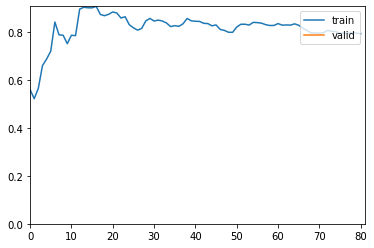

8.948701768624112e-07

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.775870,0.893435,0.734959,0.685185,0.314815,00:25


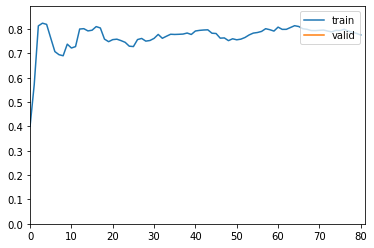

8.948701768624112e-07

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.821354,0.757043,0.721523,0.638889,0.361111,00:16


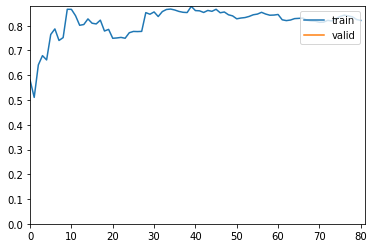

8.948701768624112e-07

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.853271,0.762625,0.770192,0.679012,0.320988,00:29


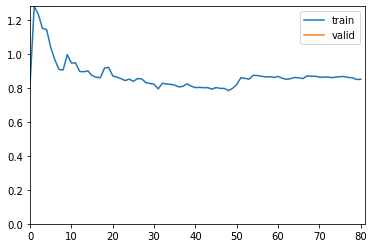

8.948701768624112e-07

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.929675,0.802544,0.752903,0.675926,0.324074,00:16


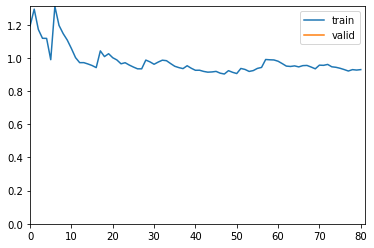

KAPPA MEAN 68.65636120245308


2.237175442156028e-07

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.795812,0.839741,0.702940,0.632716,0.367284,00:16


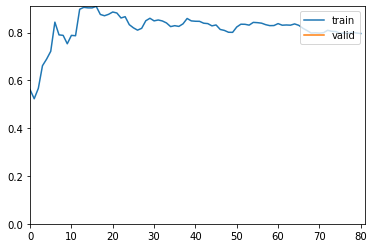

2.237175442156028e-07

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.776134,0.896033,0.736218,0.685185,0.314815,00:23


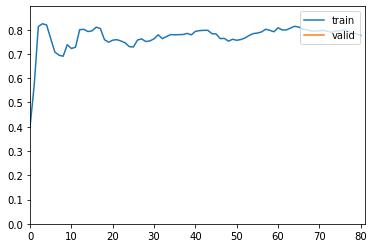

2.237175442156028e-07

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.823060,0.756071,0.725614,0.645062,0.354938,00:16


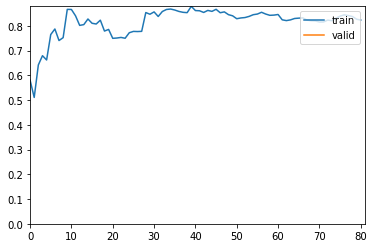

2.237175442156028e-07

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.854371,0.764611,0.764626,0.679012,0.320988,00:18


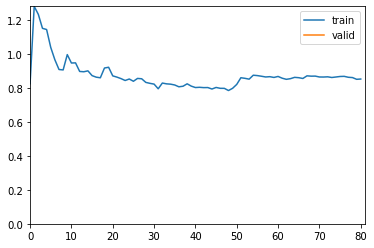

2.237175442156028e-07

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.931651,0.805661,0.756900,0.682099,0.317901,00:29


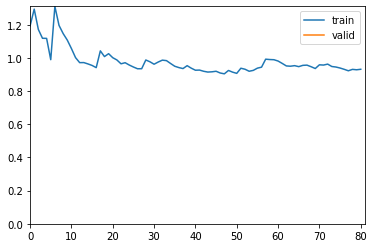

KAPPA MEAN 68.74936448755713


5.59293860539007e-08

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.796127,0.840163,0.703263,0.629630,0.370370,00:16


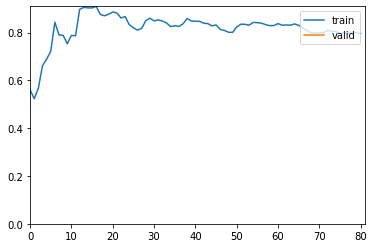

5.59293860539007e-08

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.776230,0.896750,0.737246,0.688272,0.311728,00:31


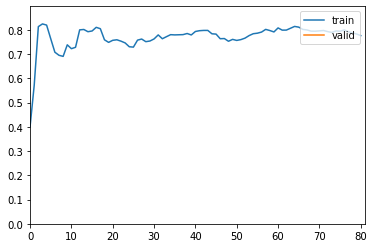

5.59293860539007e-08

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.823536,0.755852,0.720084,0.638889,0.361111,00:15


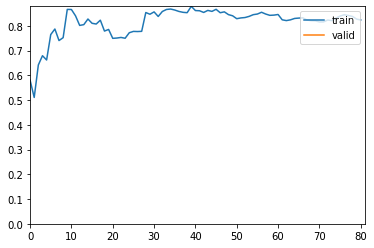

5.59293860539007e-08

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.854680,0.765157,0.764626,0.679012,0.320988,00:16


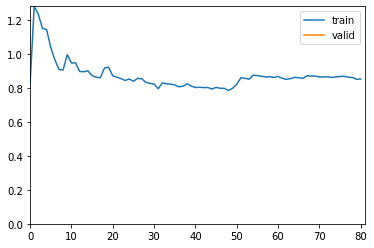

5.59293860539007e-08

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.932176,0.806511,0.756900,0.682099,0.317901,00:26


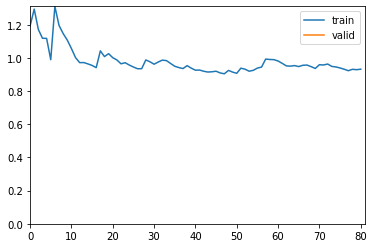

KAPPA MEAN 68.83629714560126


1.3982346513475175e-08

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.796209,0.840272,0.703263,0.629630,0.370370,00:16


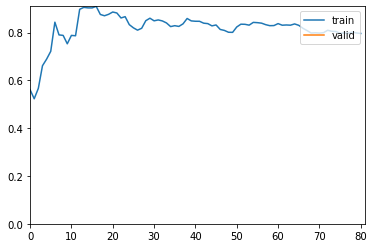

1.3982346513475175e-08

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.776257,0.896935,0.737246,0.688272,0.311728,00:16


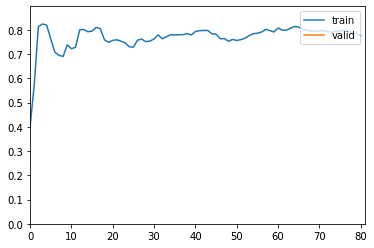

1.3982346513475175e-08

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.823657,0.755799,0.720084,0.638889,0.361111,00:25


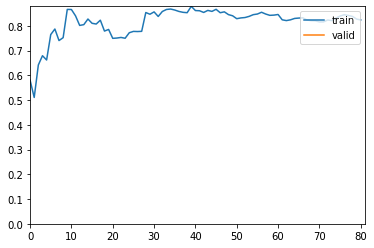

1.3982346513475175e-08

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.854760,0.765298,0.764626,0.679012,0.320988,00:16


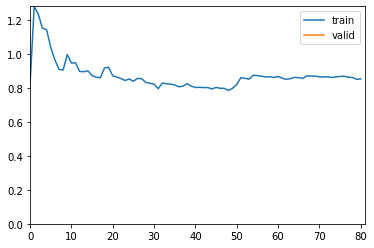

1.3982346513475175e-08

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.932308,0.806729,0.756900,0.682099,0.317901,00:28


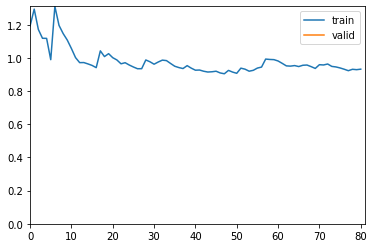

KAPPA MEAN 68.89425225096403


3.4955866283687936e-09

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.796229,0.840300,0.703263,0.629630,0.370370,00:16


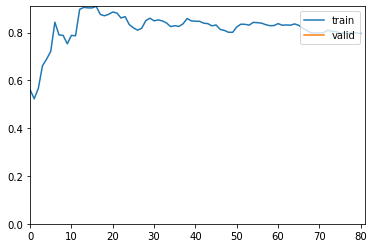

3.4955866283687936e-09

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.776264,0.896981,0.737246,0.688272,0.311728,00:17


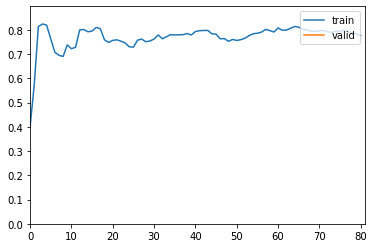

3.4955866283687936e-09

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.823689,0.755785,0.720084,0.638889,0.361111,00:27


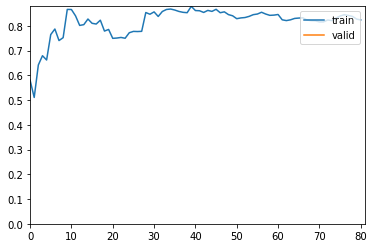

3.4955866283687936e-09

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.854781,0.765333,0.764626,0.679012,0.320988,00:16


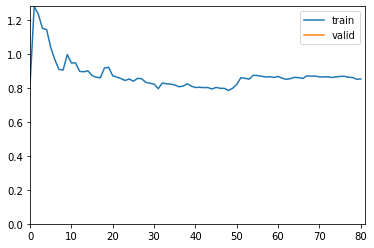

3.4955866283687936e-09

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.932341,0.806785,0.756900,0.682099,0.317901,00:16


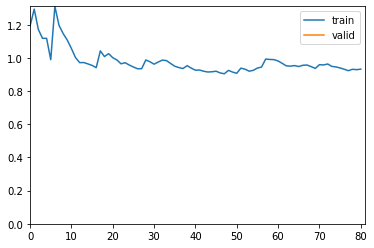

KAPPA MEAN 68.93564875479456


8.738966570921984e-10

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.796234,0.840307,0.703263,0.629630,0.370370,00:30


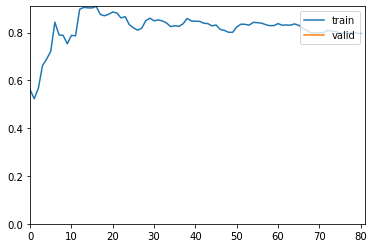

8.738966570921984e-10

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.776266,0.896993,0.737246,0.688272,0.311728,00:16


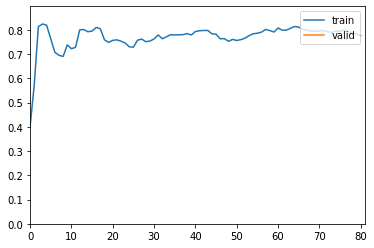

8.738966570921984e-10

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.823696,0.755782,0.720084,0.638889,0.361111,00:27


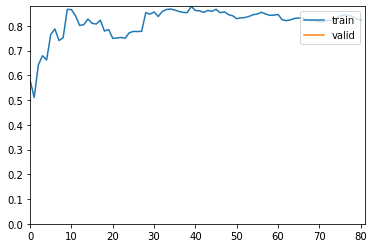

8.738966570921984e-10

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.854786,0.765342,0.764626,0.679012,0.320988,00:15


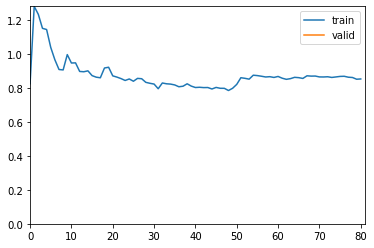

8.738966570921984e-10

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.932348,0.806799,0.756900,0.682099,0.317901,00:18


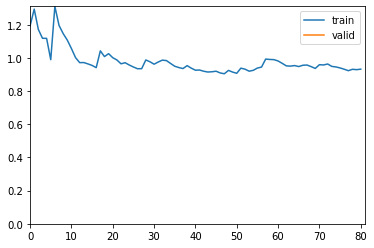

KAPPA MEAN 68.96669613266745


2.184741642730496e-10

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.796236,0.840309,0.703263,0.629630,0.370370,00:26


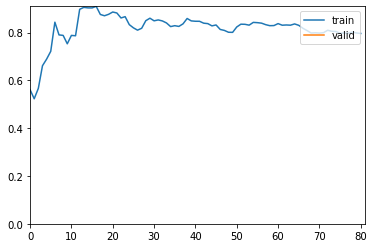

2.184741642730496e-10

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.776267,0.896997,0.737246,0.688272,0.311728,00:16


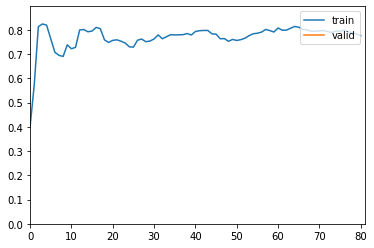

2.184741642730496e-10

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.823698,0.755781,0.720084,0.638889,0.361111,00:18


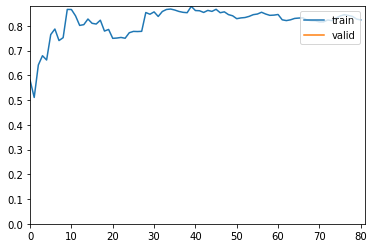

2.184741642730496e-10

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.854788,0.765344,0.764626,0.679012,0.320988,00:16


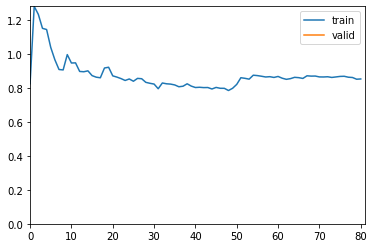

2.184741642730496e-10

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.932347,0.806803,0.756900,0.682099,0.317901,00:16


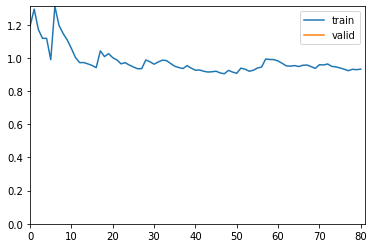

KAPPA MEAN 68.99084409323527


5.46185410682624e-11

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.796236,0.840310,0.703263,0.629630,0.370370,00:22


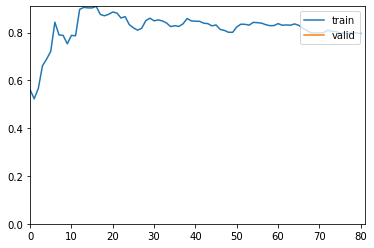

5.46185410682624e-11

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.776267,0.896998,0.737246,0.688272,0.311728,00:16


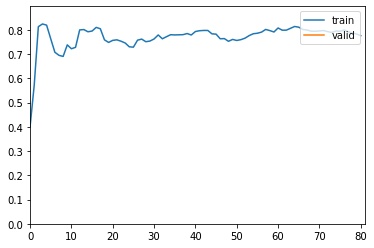

5.46185410682624e-11

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.823699,0.755780,0.720084,0.638889,0.361111,00:15


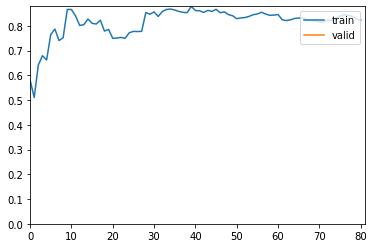

5.46185410682624e-11

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.854788,0.765345,0.764626,0.679012,0.320988,00:24


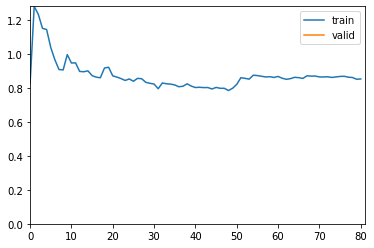

5.46185410682624e-11

epoch,train_loss,valid_loss,kappa_score,accuracy,error_rate,time
0,0.932346,0.806804,0.756900,0.682099,0.317901,00:15


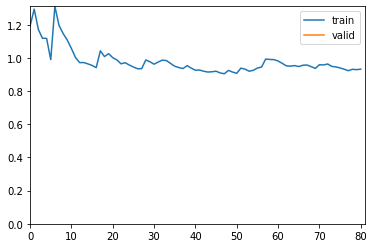

KAPPA MEAN 69.01016246168952
SAVED 5.46185410682624e-11
[]


In [22]:
seed_all(seed)
skf = StratifiedKFold(n_splits=5, shuffle=True)
val_pct = []
test_pct = []
kappas = []
learning_rates = []
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id
seed_all(seed)
bs = 16
#learning rate for cyclic momentum
lr = 1.4317922829798579e-05
lr2= 2.754228703338166e-06
#prev is the default threshold
prev = 69
score = 0
while score<prev:
    for train_index, val_index in skf.split(asap_train.index, asap_train[target_col]):
        databunch = (TextList.from_df(asap_train, cols=text_column, processor=transformer_processor)
             .split_by_idxs(train_index, val_index)
             .label_from_df(cols=target_col)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

        data_test = (TextList.from_df(asap_test, cols=text_column, processor=transformer_processor)
                 .split_none()
                 .label_from_df(cols=target_col))

        data_test.valid = data_test.train
        data_test = data_test.databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx)

        learner,num_groups = setup_learner(databunch,initial=False,model='best_all_layer_asap.pkl',path=os.path.abspath('./models'))
        learner.freeze_to(-1)
        min_grad_lr=lr
        min_grad_lr
        learner.fit_one_cycle(1,max_lr=slice(lr2,lr),moms=(0.8,0.7))
        val = learner.validate()
        learner.data.valid_dl = data_test.valid_dl
        test = learner.validate( )
        preds, y = learner.get_preds(ds_type=DatasetType.Valid)
        pred = torch.argmax(preds, dim=1)
        cohen_score = cohen_kappa_score(y, pred,weights='quadratic')
        val_pct.append(val[1].numpy())
        test_pct.append(test[1].numpy())
        kappas.append(cohen_score)
        
    k = np.mean(kappas)*100
    score = k
    print ("KAPPA MEAN",k)
    if (k>prev):
        print ("SAVED",lr)
        learner.export(os.path.abspath('./models/best_all_layersss_asap.pkl'))
    else:
        lr = lr*0.25
print (learning_rates)

In [54]:
print(f'Validation\nmean: {np.mean(val_pct)}\nstd: {np.std(val_pct)}')

Validation
mean: 0.7306786775588989
std: 0.009150248020887375
